In [1]:
from IPython.display import HTML, display
from datetime import datetime, timedelta
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)

In [3]:
CONFIG_FILE = "config.json"
LIBOR_CSV = "fred_historical_USD1MTD156N.csv"

In [4]:
START_DATE = datetime(1999, 12, 1)
END_DATE = datetime(2019, 1, 1)

In [5]:
YEARS_TO_STUDY = [
    2000,
    2004,
    2008,
    2012,
    2016,
    2018
]

In [6]:
S_P500 = "^GSPC"
STOCKS = [
    "AAPL",
    "AMZN",
    "INTC",
    "MSFT",
    "NVDA"
]
SYMBOLS = [S_P500] + STOCKS

TWO_ASSET_PORT = [0, 3]

In [7]:
def try_live_load(config_file):
    if os.path.exists(config:= os.path.join(os.getcwd(), config_file)):
        with open(config) as config_file:
            config = json.load(config_file)
            if "API_KEY" in config:
                return pd.read_json(F"https://api.tradingeconomics.com/fred/historical/USD1MTD156N?c={config['API_KEY']}").set_index(keys="date")
    return None

In [8]:
def get_risk_free_data(data_file=LIBOR_CSV, config_file=CONFIG_FILE, from_date=START_DATE+timedelta(days=1), to_date=END_DATE, keep=["value"]):
    df = try_live_load(config_file)
    if not isinstance(df, pd.DataFrame) and os.path.exists(file:= os.path.join(os.getcwd(), data_file)):
        df = pd.read_csv(file, index_col="date")
    elif not isinstance(df, pd.DataFrame):
        raise Exception("LIBOR rate data could not be imported")

    return df[keep].rename(columns={column: (F"LIBOR {column}" if len(keep) > 1 else "LIBOR") for column in df}).loc[from_date:to_date]

In [9]:
def get_risky_data(symbols, from_date=START_DATE, to_date=END_DATE, keep=["Adj Close"]):
    if isinstance(symbols, str):
        df = web.DataReader(symbols, "yahoo", from_date, to_date)[keep]
        return df.rename(columns={column: (F"{symbols} {column}" if len(keep) > 1 else symbols) for column in df})
    elif isinstance(symbols, list):
        if symbols:
            df = web.DataReader(symbols[0], "yahoo", from_date, to_date)[keep]
            df.rename(columns={column: (F"{symbols[0]} {column}" if len(keep) > 1 else symbols[0]) for column in df}, inplace=True)
            for s in symbols[1:]:
                temp = web.DataReader(s, "yahoo", from_date, to_date)[keep]
                temp.rename(columns={column: (F"{s} {column}" if len(keep) > 1 else s) for column in temp}, inplace=True)

                df = pd.merge(df, temp, how="inner", on="Date")
            return df
        else: raise ValueError("list of 'symbols' must not be empty")
    else:
        raise TypeError("'symbols' must be either a string or list of symbols")

In [10]:
stock_data = get_risky_data(SYMBOLS).sort_index()
display(HTML(stock_data.head().to_html()))

,^GSPC,AAPL,AMZN,INTC,MSFT,NVDA
Date,,,,,,
1999-12-01,1397.719971,0.787944,85.0000,23.193523,29.354944,0.696135
1999-12-02,1409.040039,0.842417,89.0625,23.573433,29.866854,0.747567
1999-12-03,1433.300049,0.879210,86.5625,23.915346,30.280281,0.729626
1999-12-06,1423.329956,0.886855,87.7500,23.668415,30.063711,0.749959
1999-12-07,1409.170044,0.900713,86.0625,23.459465,29.295876,0.724841


In [11]:
libor_data = get_risk_free_data().sort_index()
display(HTML(libor_data.head().to_html()))

libor_data = np.log(libor_data/100 + 1)
display(HTML(libor_data.head().to_html()))

,LIBOR
date,
1999-12-02,6.47875
1999-12-03,6.47875
1999-12-06,6.46875
1999-12-07,6.46750
1999-12-08,6.46875


,LIBOR
date,
1999-12-02,0.062775
1999-12-03,0.062775
1999-12-06,0.062681
1999-12-07,0.062670
1999-12-08,0.062681


In [12]:
libor_daily = libor_data.groupby(by=libor_data.index.year).apply(lambda df: df.mean()/360)
display(HTML(libor_daily.to_html()))

,LIBOR
date,
1999,0.000172
2000,0.000173
2001,0.000105
2002,0.000049
2003,0.000033
2004,0.000041
2005,0.000092
2006,0.000138
2007,0.000142


In [13]:
libor_monthly = libor_data.groupby(by=libor_data.index.year).apply(lambda df: df.mean()/12)
display(HTML(libor_monthly.to_html()))

,LIBOR
date,
1999,0.005170
2000,0.005179
2001,0.003165
2002,0.001460
2003,0.001001
2004,0.001241
2005,0.002775
2006,0.004141
2007,0.004262


In [14]:
K_daily = np.log(stock_data / stock_data.shift(1))
display(HTML(K_daily.head().to_html()))

,^GSPC,AAPL,AMZN,INTC,MSFT,NVDA
Date,,,,,,
1999-12-01,NaN,NaN,NaN,NaN,NaN,NaN
1999-12-02,0.008066,0.066848,0.046687,0.016247,0.017288,0.071281
1999-12-03,0.017071,0.042749,-0.028472,0.014400,0.013747,-0.024292
1999-12-06,-0.006980,0.008658,0.013625,-0.010379,-0.007178,0.027487
1999-12-07,-0.009998,0.015504,-0.019418,-0.008867,-0.025872,-0.034066


In [15]:
stock_data_bom = stock_data.groupby(by=[stock_data.index.year, stock_data.index.month]).first()
display(HTML(stock_data_bom.head().to_html()))
K_monthly = np.log(stock_data_bom / stock_data_bom.shift(1))
display(HTML(K_monthly.head().to_html()))

In [16]:
def mu_sigma(w, m=None, C=None, mu=True, sigma=True):
    if not mu and not sigma: return None
    ret = ()
    if sigma: ret = ret + (np.squeeze(np.sqrt(w.T @ C @ w)),)
    if mu: ret = ret + (np.squeeze(m.T @ w),)
    return ret[0] if len(ret) == 1 else ret

In [17]:
def mvp(C_inv, m, ones):
    sigma = np.squeeze(1 / np.sqrt(ones.T @ C_inv @ ones))
    w = sigma ** 2 * (C_inv @ ones)
    mu = mu_sigma(w, m, sigma=False)
    return w, sigma, mu

In [18]:
def mp(C, C_inv, m, R, ones):
    m_ex = m - R * ones

    w = (1 / np.squeeze(ones.T @ C_inv @ m_ex)) * (C_inv @ m_ex)
    sigma, mu = mu_sigma(w, m, C)
    return w, sigma, mu

In [19]:
def generate_efficient_frontier(C_inv, m, mu_MVP, mu_M):
    m_bar = np.concatenate((m, ones), axis=1)
    
    B = m_bar.T @ C_inv @ m_bar
    G = np.linalg.inv(B)

    a = G[0, 0]
    d = G[0, 1]

    mu = np.linspace(mu_MVP, mu_M*(1.5 if mu_M > 0 else .5), 1000)
    sigma = np.sqrt(a*(mu + (d/a))**2 + (1/a)*np.linalg.det(G))
    return sigma, mu

In [20]:
def capm(mu_M, R, sigma_M, sigma_v):
    beta = np.linspace(0, max(sigma_v)/sigma_M, 1000)
    mu_v = beta * (mu_M - R) + R
    return beta, mu_v

In [21]:
def no_short_normalize(w):
    w_no_short = w.copy()
    w_no_short[w_no_short < 0] = 0
    w_no_short = w_no_short / np.sum(w_no_short)
    return w_no_short

In [22]:
def beta_v(mu_V, mu_M, R):
    return (mu_V - R) / (mu_M - R)

In [23]:
def correlation_coefficient(sigma_M, sigma_V, beta_V=None, cov=None):
    if cov is None and beta_V is None: raise Exception("function requires 'beta_V' or 'cov'")
    if cov is None and beta_V is not None: cov = beta_V * (sigma_M ** 2)
    return cov / (sigma_M * sigma_V)

In [24]:
def systematic_risk(beta_V, sigma_M):
    return (beta_V ** 2) * (sigma_M ** 2)

In [25]:
def diversifiable_risk(sigma_V, systematic_risk):
    return (sigma_V ** 2) - systematic_risk

In [26]:
def print_dominations(portfolios):
    for ind, portfolio in enumerate(portfolios[:, 2]):
        dominating = portfolios[((portfolios[:, 0].astype(float) >= portfolios[ind, 0].astype(float))
                                & (portfolios[:, 1].astype(float) < portfolios[ind, 1].astype(float)))
                                | ((portfolios[:, 0].astype(float) > portfolios[ind, 0].astype(float))
                                & (portfolios[:, 1].astype(float) <= portfolios[ind, 1].astype(float))), 2]
        if dominating.size != 0: print(F"{portfolio} dominates: {', '.join(dominating)}")

Adjusting R:
	LIBOR rate: 0.00017264348302361884 >~ mu_MVP -0.0036698453746373087


<Figure size 432x288 with 0 Axes>

There is no overall dominating portfolio
MVP dominates: MP (2 Assets)
MVP (No Short) dominates: MP (2 Assets)
S&P 500 dominates: MVP, MVP (No Short), MP (No Short), MP (2 Assets)


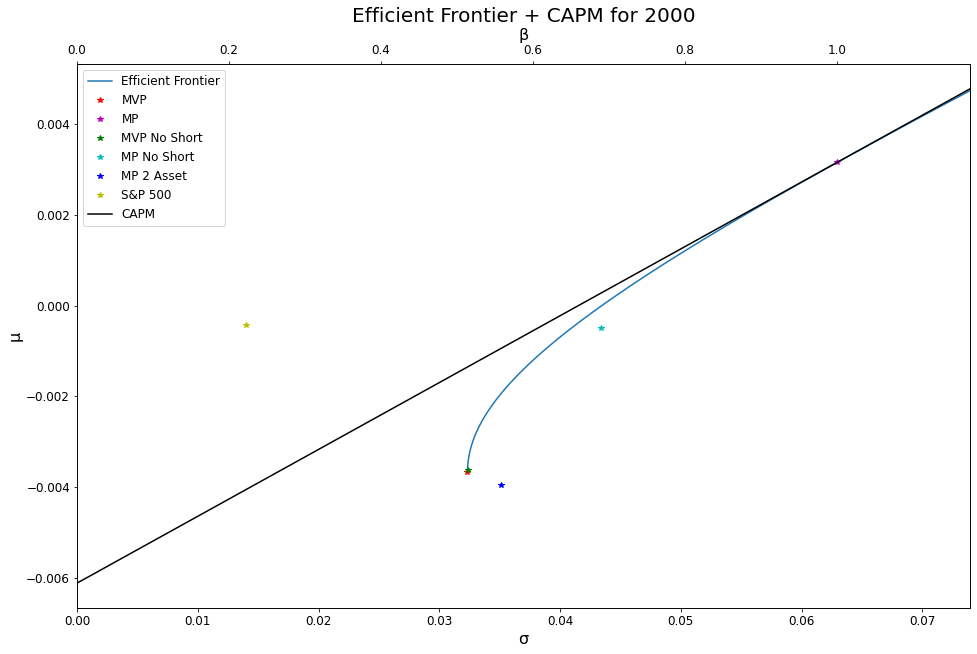

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M,σ_MVP (No Short),μ_MVP (No Short),σ_M (No Short),μ_M (No Short),σ_M (2 Asset),μ_M (2 Asset),ρ_M2_M,β_V,Systematic Risk,Diversifiable Risk,C stability,σ_S&P500,μ_S&P500,ρ_MVP_SP500,ρ_M_SP500,ρ_MVPns_SP500,ρ_Mns_SP500,ρ_M2_SP500
0,2000,0.032334,-0.00367,0.000173,-0.006116,0.062949,0.003157,0.03234,-0.003622,0.04337,-0.000493,0.035074,-0.003965,0.41641,0.232016,0.000213,0.001017,10.505027,0.014002,-0.000424,0.667948,0.412926,0.669417,0.600119,0.548082


<Figure size 432x288 with 0 Axes>

There is no overall dominating portfolio
MVP dominates: MVP (No Short)


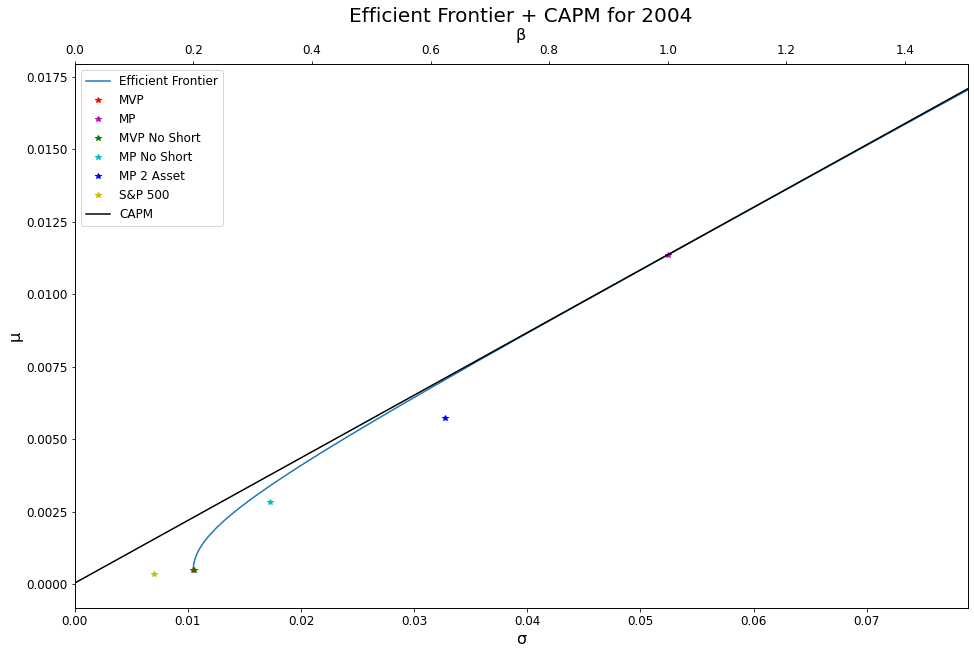

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M,σ_MVP (No Short),μ_MVP (No Short),σ_M (No Short),μ_M (No Short),σ_M (2 Asset),μ_M (2 Asset),ρ_M2_M,β_V,Systematic Risk,Diversifiable Risk,C stability,σ_S&P500,μ_S&P500,ρ_MVP_SP500,ρ_M_SP500,ρ_MVPns_SP500,ρ_Mns_SP500,ρ_M2_SP500
0,2004,0.010482,0.000494,0.000041,0.000041,0.052416,0.011363,0.01057,0.000479,0.017267,0.002837,0.032693,0.005749,0.808301,0.504158,0.000698,0.000371,24.138962,0.006988,0.000342,0.630281,0.050745,0.667148,0.504204,0.325346



Adjusting R:
	LIBOR rate: 7.346458134416215e-05 >~ mu_MVP -0.0023268622163653122


<Figure size 432x288 with 0 Axes>

There is no overall dominating portfolio
MVP dominates: MVP (No Short)
S&P 500 dominates: MVP, MVP (No Short), MP (No Short)


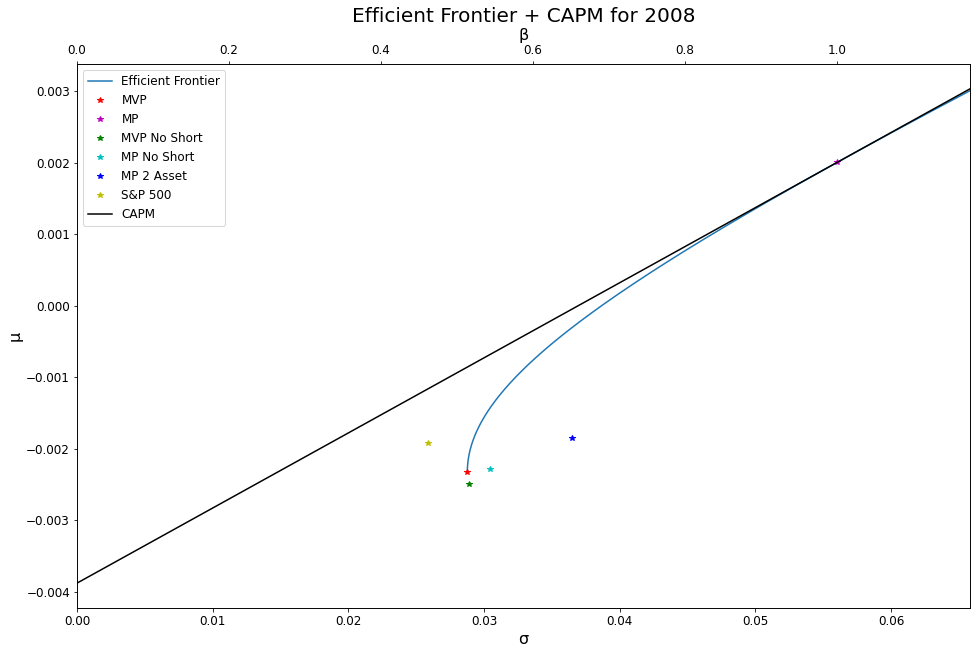

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M,σ_MVP (No Short),μ_MVP (No Short),σ_M (No Short),μ_M (No Short),σ_M (2 Asset),μ_M (2 Asset),ρ_M2_M,β_V,Systematic Risk,Diversifiable Risk,C stability,σ_S&P500,μ_S&P500,ρ_MVP_SP500,ρ_M_SP500,ρ_MVPns_SP500,ρ_Mns_SP500,ρ_M2_SP500
0,2008,0.028767,-0.002327,0.000073,-0.003878,0.056021,0.002005,0.028882,-0.002498,0.030438,-0.002285,0.036504,-0.001848,0.529656,0.345133,0.000374,0.000959,22.285006,0.02584,-0.001921,0.848378,0.350134,0.866073,0.869422,0.653743


<Figure size 432x288 with 0 Axes>

There is no overall dominating portfolio
MVP dominates: MVP (No Short)
S&P 500 dominates: MVP, MVP (No Short)


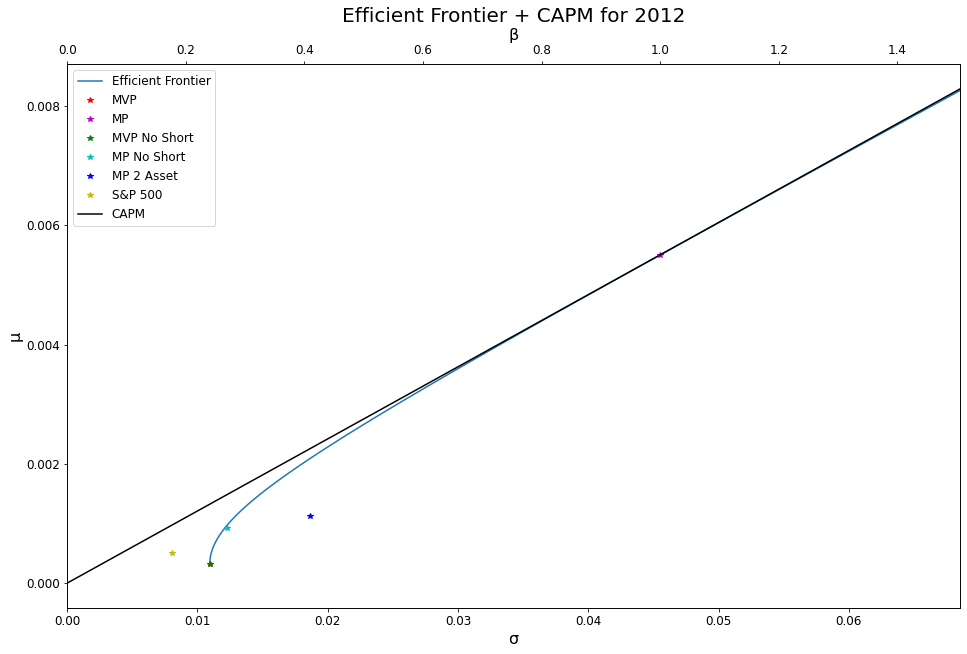

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M,σ_MVP (No Short),μ_MVP (No Short),σ_M (No Short),μ_M (No Short),σ_M (2 Asset),μ_M (2 Asset),ρ_M2_M,β_V,Systematic Risk,Diversifiable Risk,C stability,σ_S&P500,μ_S&P500,ρ_MVP_SP500,ρ_M_SP500,ρ_MVPns_SP500,ρ_Mns_SP500,ρ_M2_SP500
0,2012,0.01094,0.000324,0.000007,0.000007,0.04551,0.005503,0.01094,0.000323,0.012282,0.000937,0.018603,0.001136,0.502848,0.205552,0.000088,0.000259,10.489764,0.008037,0.000503,0.827654,0.215188,0.827875,0.756489,0.544405


<Figure size 432x288 with 0 Axes>

There is no overall dominating portfolio


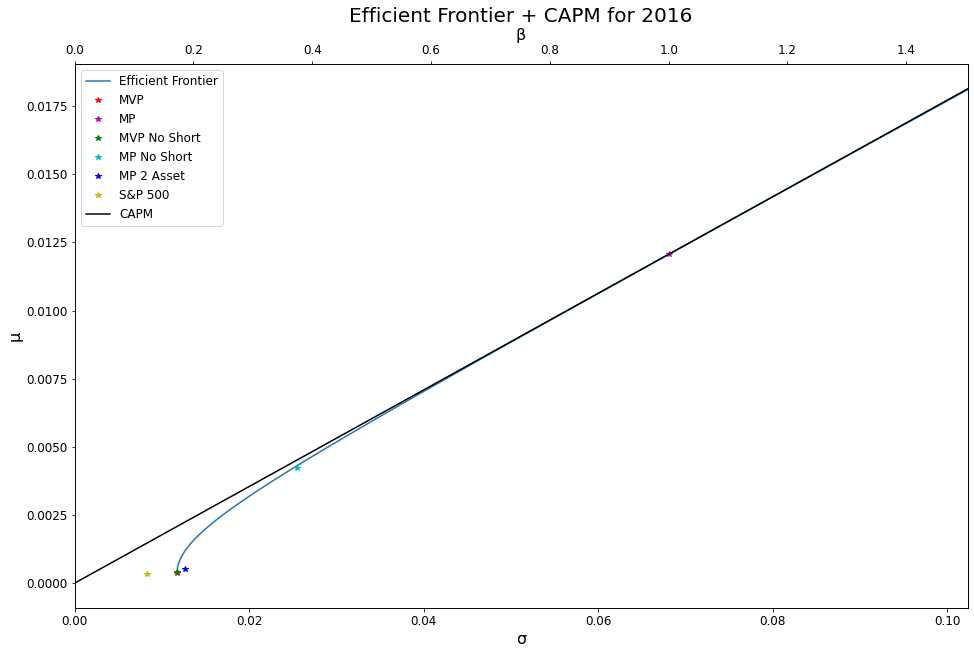

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M,σ_MVP (No Short),μ_MVP (No Short),σ_M (No Short),μ_M (No Short),σ_M (2 Asset),μ_M (2 Asset),ρ_M2_M,β_V,Systematic Risk,Diversifiable Risk,C stability,σ_S&P500,μ_S&P500,ρ_MVP_SP500,ρ_M_SP500,ρ_MVPns_SP500,ρ_Mns_SP500,ρ_M2_SP500
0,2016,0.011726,0.000371,0.000014,0.000014,0.068063,0.012059,0.011732,0.000438,0.025424,0.004227,0.01269,0.000527,0.228376,0.042579,0.000008,0.000153,13.041808,0.00826,0.000361,0.81049,0.184307,0.812204,0.432872,0.750434


<Figure size 432x288 with 0 Axes>

There is no overall dominating portfolio
MVP dominates: MVP (No Short)


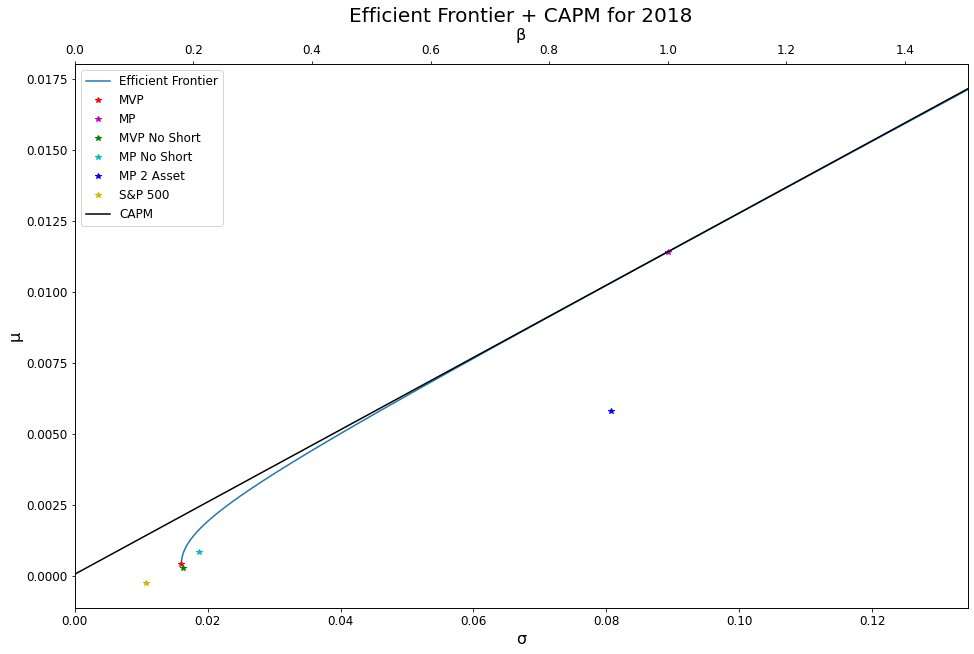

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M,σ_MVP (No Short),μ_MVP (No Short),σ_M (No Short),μ_M (No Short),σ_M (2 Asset),μ_M (2 Asset),ρ_M2_M,β_V,Systematic Risk,Diversifiable Risk,C stability,σ_S&P500,μ_S&P500,ρ_MVP_SP500,ρ_M_SP500,ρ_MVPns_SP500,ρ_Mns_SP500,ρ_M2_SP500
0,2018,0.016058,0.000423,0.000056,0.000056,0.089257,0.011407,0.016292,0.000277,0.01865,0.000829,0.080764,0.0058,0.559263,0.506048,0.00204,0.004483,25.436016,0.010771,-0.000257,0.866468,0.144344,0.899179,0.876726,0.323629


In [27]:
for year in YEARS_TO_STUDY:
    df = pd.DataFrame(data={"Year": [year]})

    w_dict = {}

    K = K_daily[STOCKS].loc[datetime(year, 1, 1):datetime(year+1, 1, 1)]

    ## 1
    m = K.mean().to_frame(name="m")
    #print(m)

    C = np.cov(K.values, rowvar=False)
    #print(np.sqrt(C))

    ## 2
    ones = np.ones((C.shape[0], 1))
    C_inv = np.linalg.inv(C)

    w_MVP, sigma_MVP, mu_MVP = mvp(C_inv, m.values, ones)
    w_dict["MVP"] = w_MVP

    #print(w_MVP)
    df["σ_MVP"] = sigma_MVP
    df["μ_MVP"] = mu_MVP

    R = np.squeeze(libor_daily.loc[year].values)
    df["LIBOR"] = R
    if R >= (.9 if mu_MVP > 0 else 1.1)*mu_MVP:
        print("Adjusting R:")
        print(F"\tLIBOR rate: {R} >~ mu_MVP {mu_MVP}")
        R = ((1/3) if mu_MVP > 0 else (5/3))*mu_MVP
    df["R"] = R

    w_M, sigma_M, mu_M = mp(C, C_inv, m.values, R, ones)
    w_dict["M"] = w_M

    #print(w_M)
    df["σ_M"] = sigma_M
    df["μ_M"] = mu_M


    ## 3
    sigma_v, mu_v = generate_efficient_frontier(C_inv, m.values, mu_MVP, mu_M)
    beta, mu_v_capm = capm(mu_M, R, sigma_M, sigma_v)


    ## 4


    ## 5
    w_MVP_no_short = no_short_normalize(w_MVP)
    sigma_MVP_no_short, mu_MVP_no_short = mu_sigma(w_MVP_no_short, m.values, C)
    w_dict["MVPns"] = w_MVP_no_short

    #print(w_MVP_no_short)
    df["σ_MVP (No Short)"] = sigma_MVP_no_short
    df["μ_MVP (No Short)"] = mu_MVP_no_short

    w_M_no_short = no_short_normalize(w_M)
    sigma_M_no_short, mu_M_no_short = mu_sigma(w_M_no_short, m.values, C)
    w_dict["Mns"] = w_M_no_short

    #print(w_M_no_short)
    df["σ_M (No Short)"] = sigma_M_no_short
    df["μ_M (No Short)"] = mu_M_no_short


    ## 6

    C_2 = C[TWO_ASSET_PORT][:, TWO_ASSET_PORT]

    ones_2 = np.ones((C_2.shape[0], 1))
    C_2_inv = np.linalg.inv(C_2)

    w_M_2, sigma_M_2, mu_M_2 = mp(C_2, C_2_inv, m.loc[[STOCKS[i] for i in TWO_ASSET_PORT]].values, R, ones_2)
    
    w_M_2_exp = np.zeros(w_M.shape)
    w_M_2_exp[TWO_ASSET_PORT] = w_M_2
    w_dict["M2"] = w_M_2_exp
    
    #print(w_M_2)
    df["σ_M (2 Asset)"] = sigma_M_2
    df["μ_M (2 Asset)"] = mu_M_2

    beta_V = beta_v(mu_M_2, mu_M, R)
    rho = correlation_coefficient(sigma_M, sigma_M_2, beta_V=beta_V)
    sys_risk = systematic_risk(beta_V, sigma_M)
    div_risk = diversifiable_risk(sigma_M_2, sys_risk)

    df["ρ_M2_M"] = rho
    df["β_V"] = beta_V
    df["Systematic Risk"] = sys_risk
    df["Diversifiable Risk"] = div_risk


    ## 7

    # a
    eigen_values, _ = np.linalg.eig(C)

    # b
    stability = max(eigen_values) / min(eigen_values)
    df["C stability"] = stability

    # c
    plt.figure()
    plt.show()


    ## 8

    K_sp500 = K_daily[S_P500].loc[datetime(year, 1, 1):datetime(year+1, 1, 1)]
    mu_sp500 = np.squeeze(K_sp500.mean())
    sigma_sp500 = np.sqrt(np.var(K_sp500, ddof=1))

    df["σ_S&P500"] = sigma_sp500
    df["μ_S&P500"] = mu_sp500


    ## 9

    portfolios = np.array([
        (sigma_MVP, mu_MVP, "MVP", "MVP"),
        (sigma_M, mu_M, "MP", "M"),
        (sigma_MVP_no_short, mu_MVP_no_short, "MVP (No Short)", "MVPns"),
        (sigma_M_no_short, mu_M_no_short, "MP (No Short)", "Mns"),
        (sigma_M_2, mu_M_2, "MP (2 Assets)", "M2"),
        (sigma_sp500, mu_sp500, "S&P 500", "SP500")
    ])

    if ((dominant:= np.argmin(portfolios[:, 0].astype(float))) == np.argmax(portfolios[:, 1].astype(float))):
        print(F"There exists an overall dominating portfolio: {portfolios[dominant, 2]}")
    else:
        print("There is no overall dominating portfolio")

    print_dominations(portfolios)

    df[[F"ρ_{abbrev}_{portfolios[-1, 3]}" for abbrev in portfolios[:-1, 3]]] = [
        correlation_coefficient(portfolios[ind, 0].astype(float),
                                portfolios[-1, 0].astype(float),
                                cov=np.cov(K_sp500, K @ w_dict[portfolio], rowvar=False)[0, 1])
        for ind, portfolio in enumerate(portfolios[:-1, 3])
    ]


    # plotting code
    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(111)

    lines = []
    lines += ax1.plot(sigma_v, mu_v, label="Efficient Frontier")
    lines += ax1.plot(sigma_MVP, mu_MVP, "r*", label="MVP")
    lines += ax1.plot(sigma_M, mu_M, "m*", label="MP")
    lines += ax1.plot(sigma_MVP_no_short, mu_MVP_no_short, "g*", label="MVP No Short")
    lines += ax1.plot(sigma_M_no_short, mu_M_no_short, "c*", label="MP No Short")
    lines += ax1.plot(sigma_M_2, mu_M_2, "b*", label="MP 2 Asset")
    lines += ax1.plot(sigma_sp500, mu_sp500, "y*", label="S&P 500")

    ax2 = ax1.twiny()
    lines += ax2.plot(beta, mu_v_capm, "black", label="CAPM")

    ax1.legend(lines, [l.get_label() for l in lines])

    ax1.set_title(F"Efficient Frontier + CAPM for {year}")
    ax1.set_xlabel("σ")
    ax2.set_xlabel("β")
    ax1.set_ylabel("μ")
    ax1.set_xlim(0, max(sigma_v))
    ax2.set_xlim(min(beta), max(beta))
    plt.show()

    display(HTML(df.to_html()))

    print()